In [1]:
import xarray as xr
from ccores import cores
import ccores.constants as cnst
import matplotlib.pyplot as plt
import os

In [95]:
dat = xr.open_dataarray(cnst.TESTDATA).squeeze()

In [96]:
dat

<xarray.DataArray 'tir' (lat: 450, lon: 1558)>
[701100 values with dtype=int16]
Coordinates:
    time     datetime64[ns] 2019-09-15T18:30:00
  * lat      (lat) float64 4.027 4.054 4.081 4.108 ... 15.92 15.95 15.97 16.0
  * lon      (lon) float64 -16.98 -16.95 -16.92 -16.9 ... 24.9 24.93 24.96 24.98

Minimum temperature in image: <xarray.DataArray 'tir' ()>
array(-9000, dtype=int16)
Coordinates:
    time     datetime64[ns] 2019-09-15T18:30:00


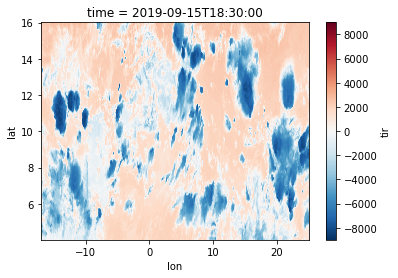

In [97]:
dat.plot()
print('Minimum temperature in image:', dat.min())

In [98]:
# Let's zoom in
dat = dat.sel(lat=slice(4,14), lon=slice(13,24))

### The temperatures in the input image have to be in degC. To save space, the test data was saved in tir*100 integers. This needs to be corrected before applying CCores!
dat = dat/100
print(dat.min())

<xarray.DataArray 'tir' ()>
array(-86.48)
Coordinates:
    time     datetime64[ns] 2019-09-15T18:30:00


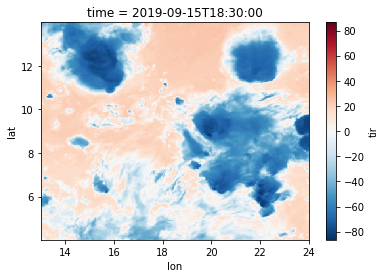

In [99]:
dat.plot()

In [100]:
perfect_dat = dat.values

In [124]:
nan_dat = dat.values.copy()
xpos = int(nan_dat.shape[1]/5)
ypos = int(nan_dat.shape[0]/5)
nan_dat[:, xpos:xpos+50] = np.nan 
nan_dat[ypos:ypos+50, :] = np.nan 

Text(0.5, 1.0, 'Faulty Meteosat image')

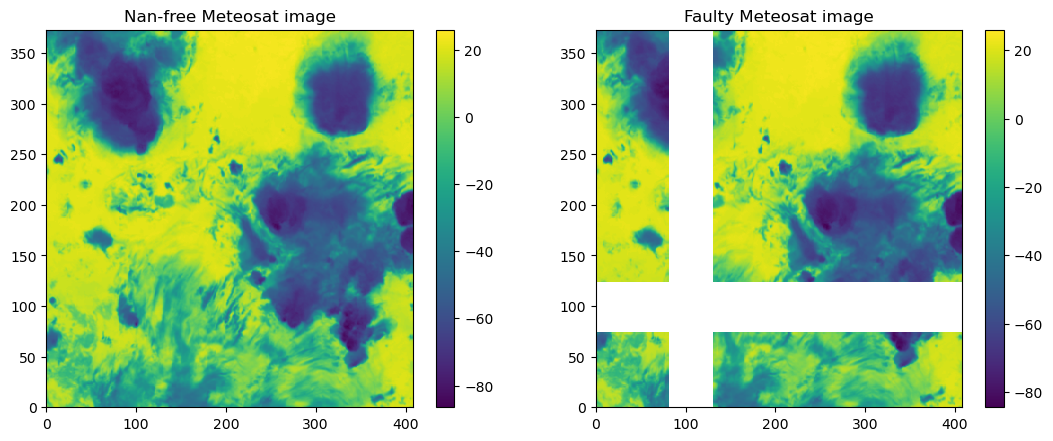

In [125]:
### For test purposes, we introduce some NaNs to create a second image

f = plt.figure(figsize=(13,5), dpi=100)
ax = f.add_subplot(121)
plt.pcolormesh(perfect_dat)
plt.colorbar()
plt.title('Nan-free Meteosat image')
ax = f.add_subplot(122)
plt.pcolormesh(nan_dat)
plt.colorbar()
plt.title('Faulty Meteosat image')

In [126]:
### Create a wavelet decomposition object first. In this example, we initialise the NFLICS nowcasting 5km setup. The setups can be defined in ccores.constants
wObj = cores.dataset('METEOSAT5K_vera')

Initialised wavelet with scales:  [25.         35.35533906 50.        ]


In [127]:
### The wObj object saves certain infos on the initialised wavelet as well as the dataset the wavelet it supposed to be used on. IT IS IMPORTANT THAT THE INITIALISED WAVELET KNOWS ABOUT THE DATASET RESOLUTION

print('Initialised dataset resolution (info from utility function):', wObj.res)
print('Initialised wavelet scale start (info from utility function):',wObj.start)
print('Initialised scale numbers (info from utility function):',wObj.nb)
print('Initialised scales:', wObj.scales)

Initialised dataset resolution (info from utility function): 5
Initialised wavelet scale start (info from utility function): 25
Initialised scale numbers (info from utility function): 2
Initialised scales: [25.         35.35533906 50.        ]


In [148]:
### The next step prepares the tir image for the wavelet routine. 'Perfect image' example, WITH edge smoothing.
wObj.read_img(perfect_dat, dat.lon.values, dat.lat.values, edge_smoothing=True)

outmin -86.48 0.0


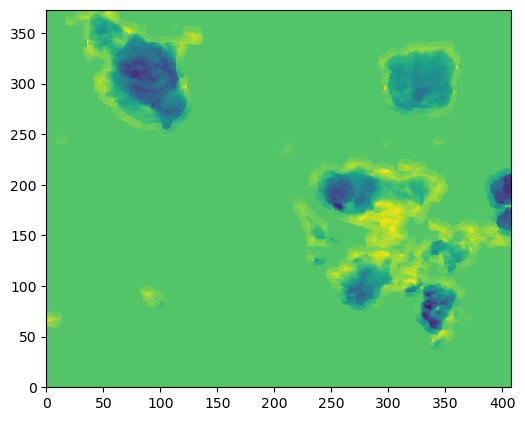

In [149]:
### The object saves the filtered image
f = plt.figure(figsize=(6,5), dpi=100)
ax = f.add_subplot(111)
plt.pcolormesh(wObj.image)

outmin -86.48 0.0


Text(0.5, 1.0, 'PERFECT IMAGE - pre-processed')

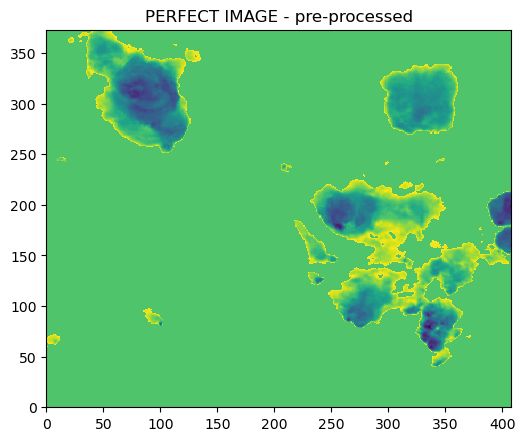

In [150]:
### 'Perfect image' example, WITHOUT edge smoothing.
wObj.read_img(perfect_dat, dat.lon.values, dat.lat.values, edge_smoothing=False)
perfect_filtered_img = wObj.image

f = plt.figure(figsize=(6,5), dpi=100)
ax = f.add_subplot(111)
plt.pcolormesh(perfect_filtered_img)
plt.title('PERFECT IMAGE - pre-processed')

In [151]:
# We now apply the wavelet scale decomposition to the image as defined in the wObj object. This step saves wavelet coefficients and powers to the object.
# The resulting powers could be used for diverse analyses. CCores offers some filtering utilities.

wObj.applyWavelet()

In [152]:
wObj.power.shape   # 0 dimension corresponds to number of decomposed scales

(3, 373, 408)

Text(0.5, 1.0, '50.0 km scale')

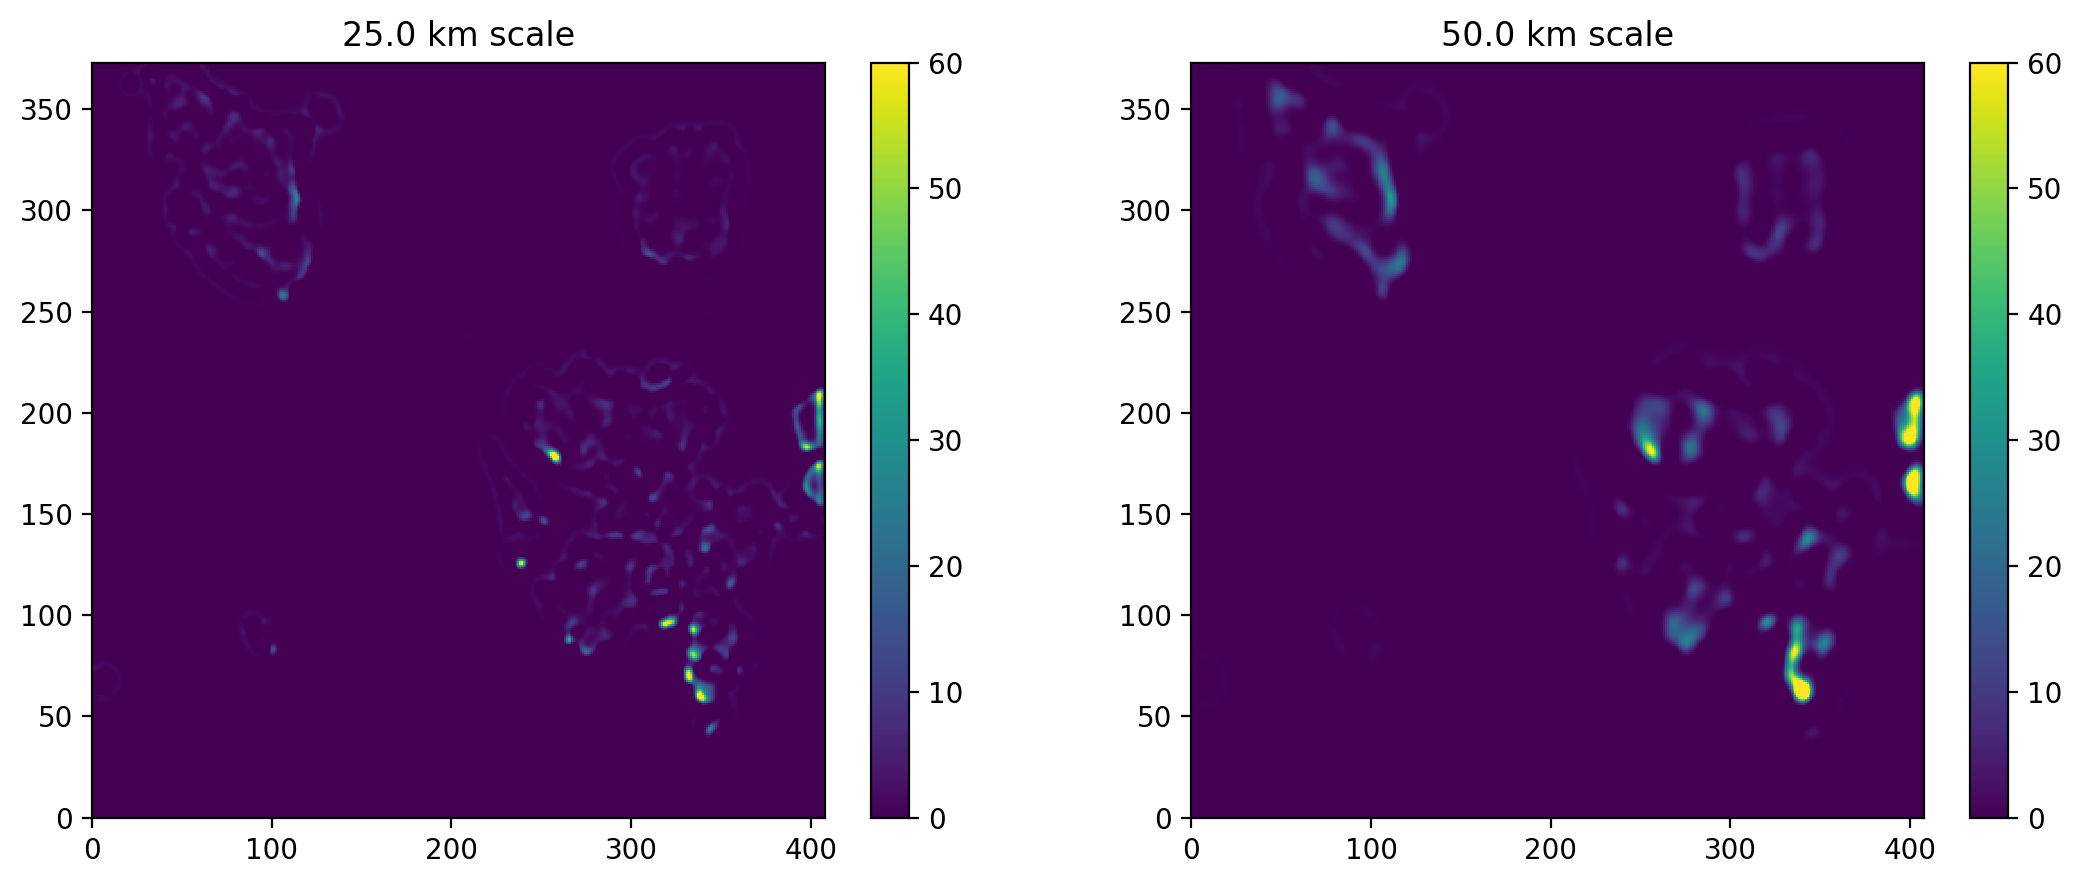

In [153]:
### This shows images of the full power spectrum for 2 of the 3 scales (note: the defined wavelet scale decomposition only considered 3 scales) according to 'METEOSAT5K_vera' in ccores.constants.

f = plt.figure(figsize=(13,5), dpi=200)

ax = f.add_subplot(121)
scale_id = 0
plt.pcolormesh(wObj.power[scale_id,:,:], vmax=60)
plt.colorbar()
plt.title(str(wObj.scales[scale_id])+' km scale')


ax = f.add_subplot(122)
scale_id = 2

plt.pcolormesh(wObj.power[scale_id,:,:], vmax=60)
plt.colorbar()
plt.title(str(wObj.scales[scale_id])+' km scale')

Text(0.5, 1.0, 'Contours: 50.0 km scale cores')

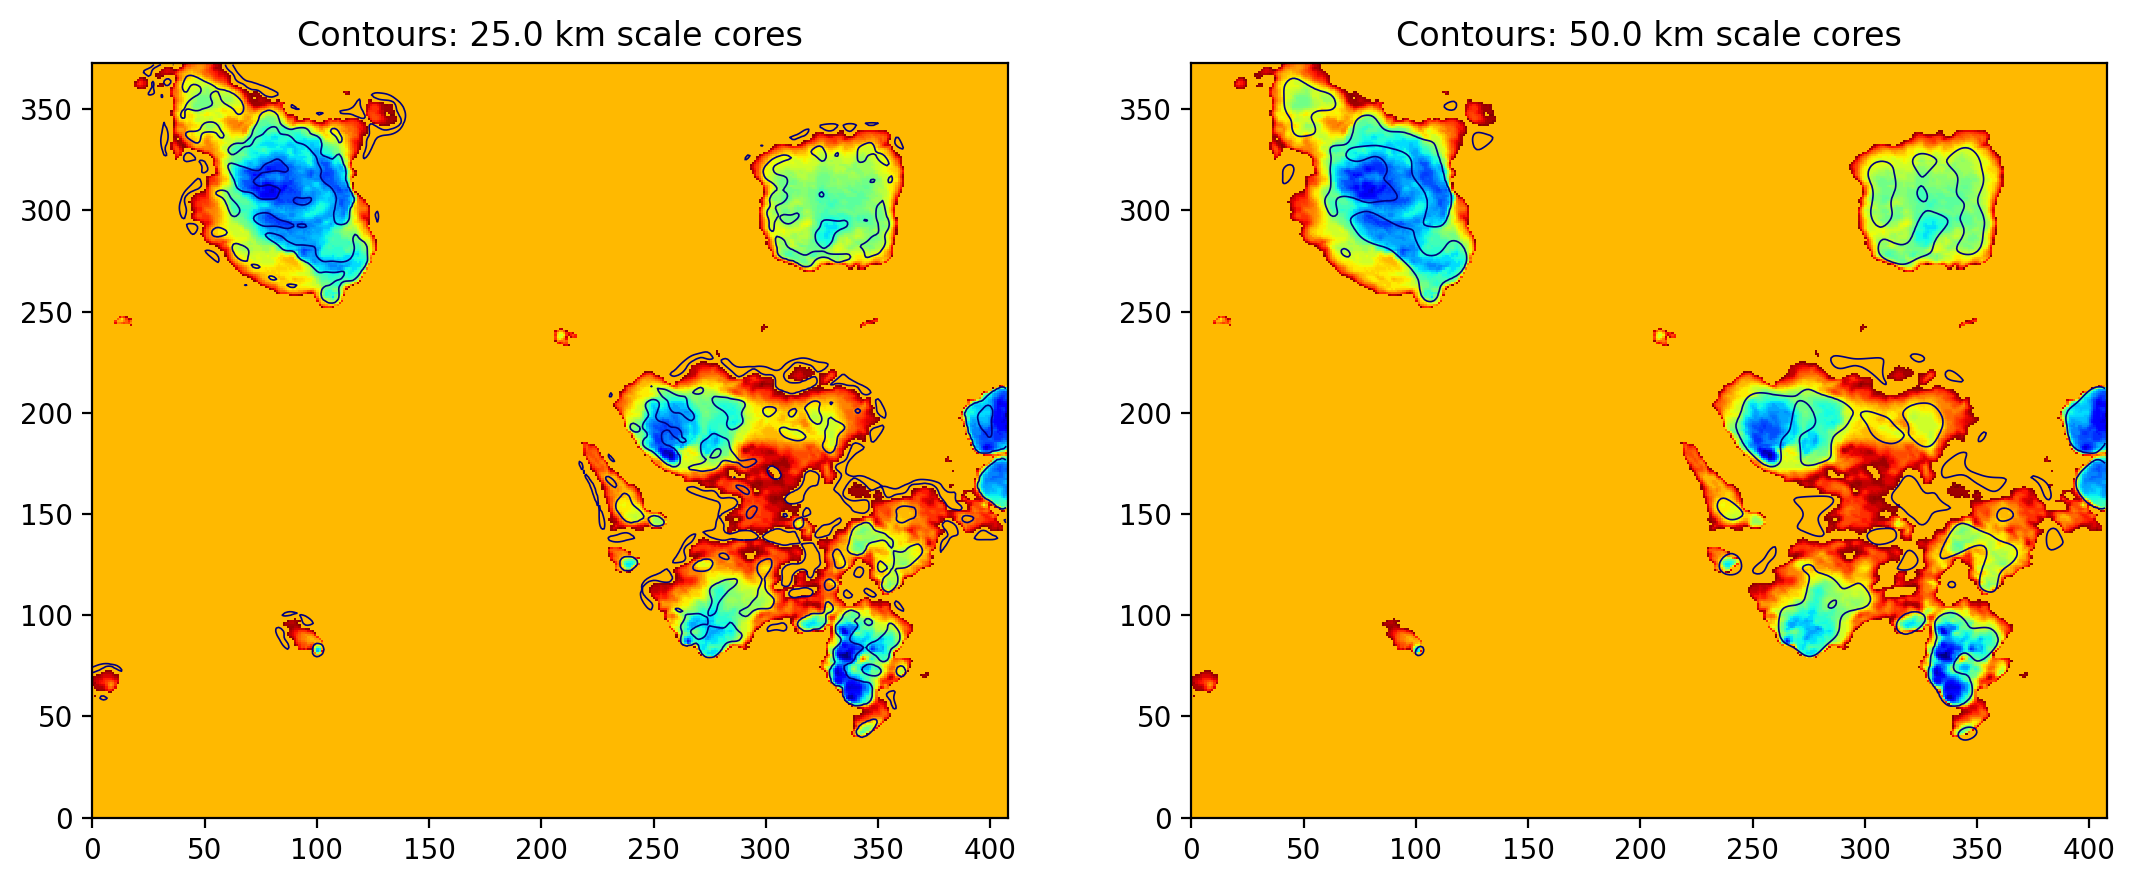

In [154]:
### Same powers as above but as contours plotted onto the thermal-infrared image. 

f = plt.figure(figsize=(13,11), dpi=200)

ax = f.add_subplot(221)

plt.pcolormesh(wObj.image, vmax=-50, vmin=-85, cmap='jet')
scale_id = 0
plt.contour(wObj.power[scale_id,:,:], levels=[0,1], cmap='jet_r', linewidths=0.6)
plt.title('Contours: '+str(wObj.scales[scale_id])+' km scale cores')

ax = f.add_subplot(222)
scale_id = 2
plt.pcolormesh(wObj.image, vmax=-50, vmin=-85, cmap='jet')
plt.contour(wObj.power[scale_id,:,:], levels=[0,1], cmap='jet_r', linewidths=0.6)
plt.title('Contours: '+str(wObj.scales[scale_id])+' km scale cores')

In [155]:
filtered_power = wObj.scaleWeighting(wtype='nflics')

Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting


Text(0.5, 1.0, 'Contours: Nflics FILTERED cores from power values')

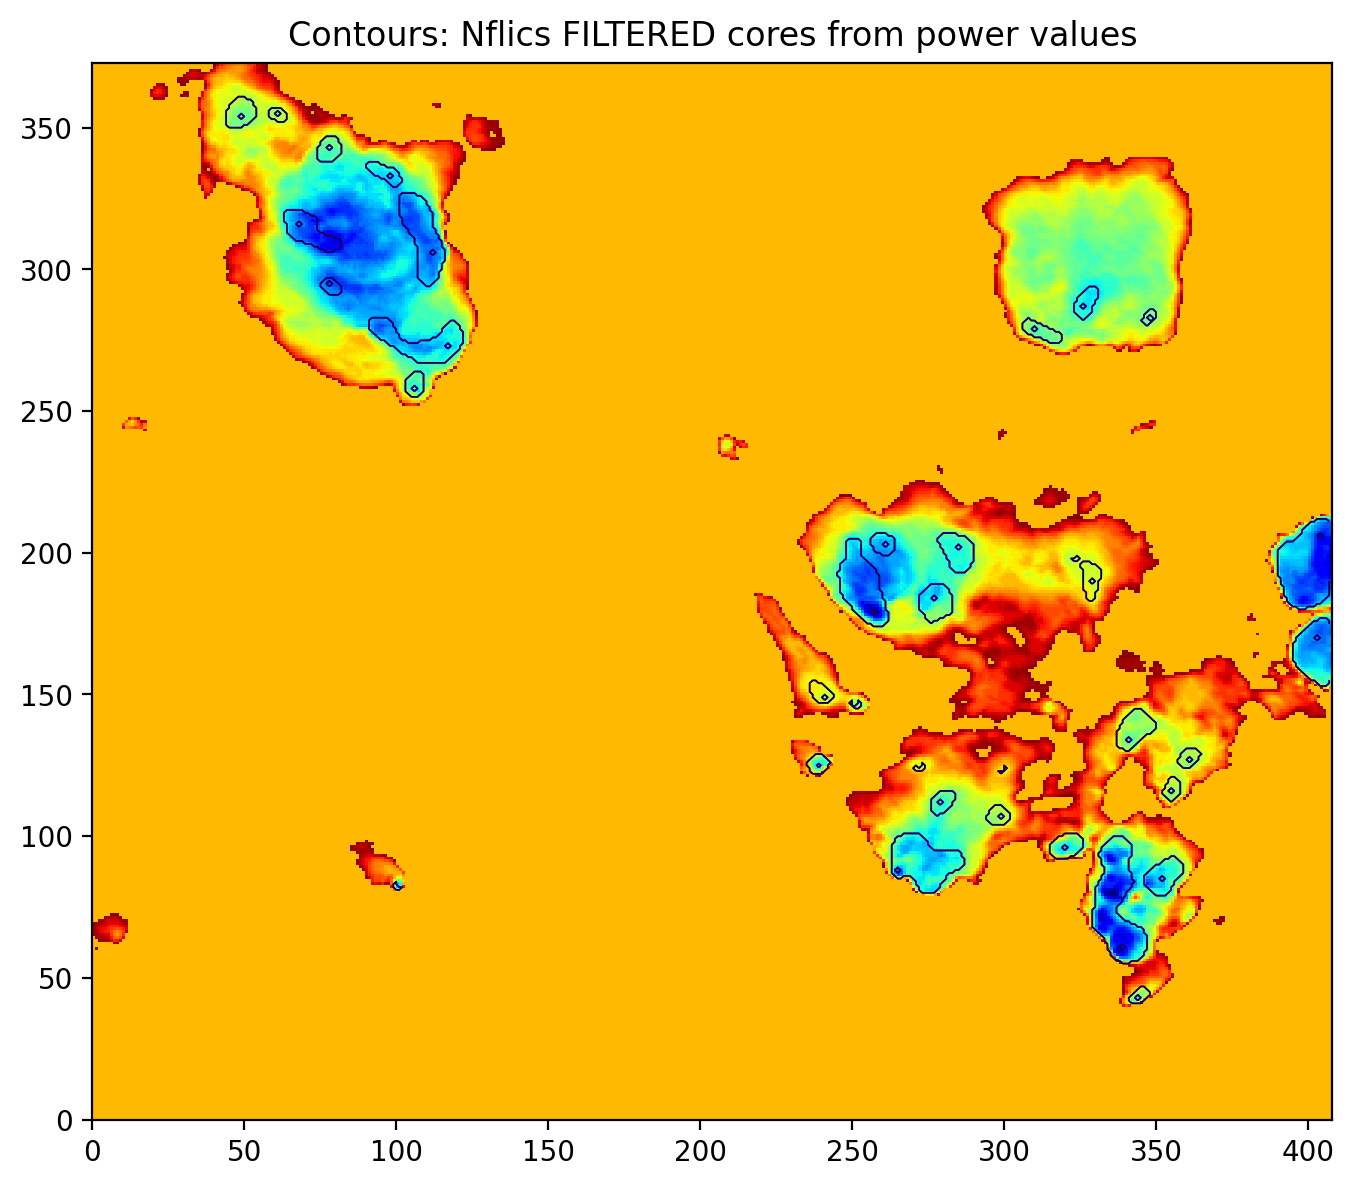

In [156]:
### For test purposes, we introduce some NaNs to create a second image

f = plt.figure(figsize=(8,7), dpi=200)

ax = f.add_subplot(111)

plt.pcolormesh(wObj.image, vmax=-50, vmin=-85, cmap='jet')

plt.contour(filtered_power, levels=[0,1], cmap='jet_r', linewidths=0.6)
plt.title('Contours: Nflics FILTERED cores from power values')

In [157]:
# We use the same wObj object again but repeat all steps with the faulty image:
wObj.read_img(nan_dat, dat.lon.values, dat.lat.values, edge_smoothing=False)
nan_filtered_image = wObj.image

outmin -84.47 0.0


Text(0.5, 1.0, 'Faulty image - pre-processed')

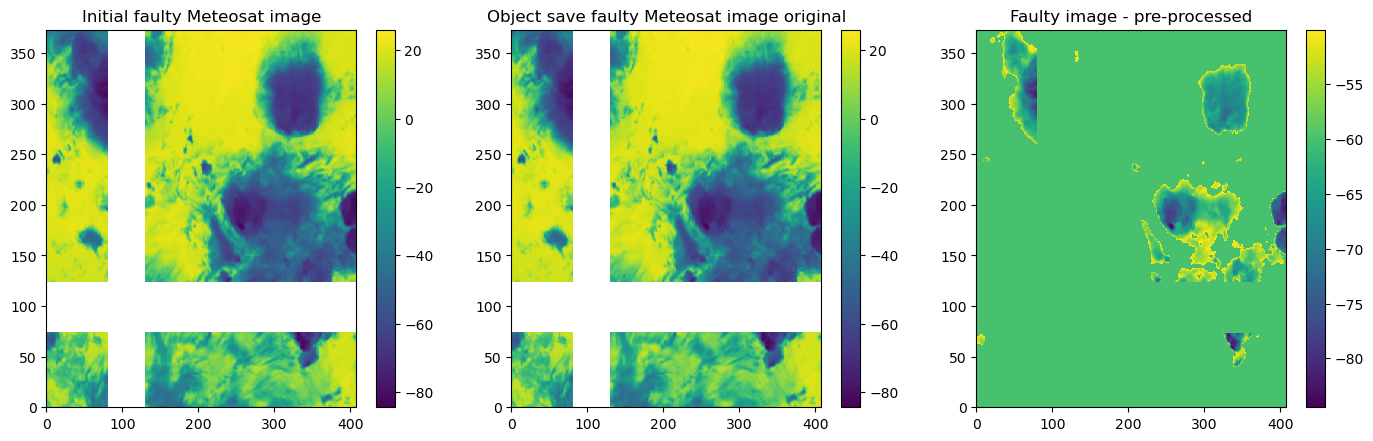

In [158]:
f = plt.figure(figsize=(17,5), dpi=100)
ax = f.add_subplot(131)
plt.pcolormesh(nan_dat)
plt.colorbar()
plt.title('Initial faulty Meteosat image')
ax = f.add_subplot(132)
plt.pcolormesh(wObj.original)
plt.colorbar()
plt.title('Object save faulty Meteosat image original')
ax = f.add_subplot(133)
plt.pcolormesh(wObj.image)
plt.colorbar()
plt.title('Faulty image - pre-processed')

In [159]:
print(nan_dat.shape)
print(wObj.image.shape)
print(wObj.original.shape)

(373, 408)
(373, 408)
(373, 408)


In [160]:
# Apply wavelet and NFLICS filter again
wObj.applyWavelet()
filtered_power_faulty = wObj.scaleWeighting(wtype='nflics')

Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting


Text(0.5, 1.0, 'Contours: PERFECT image NFLICS FILTERED cores from power values')

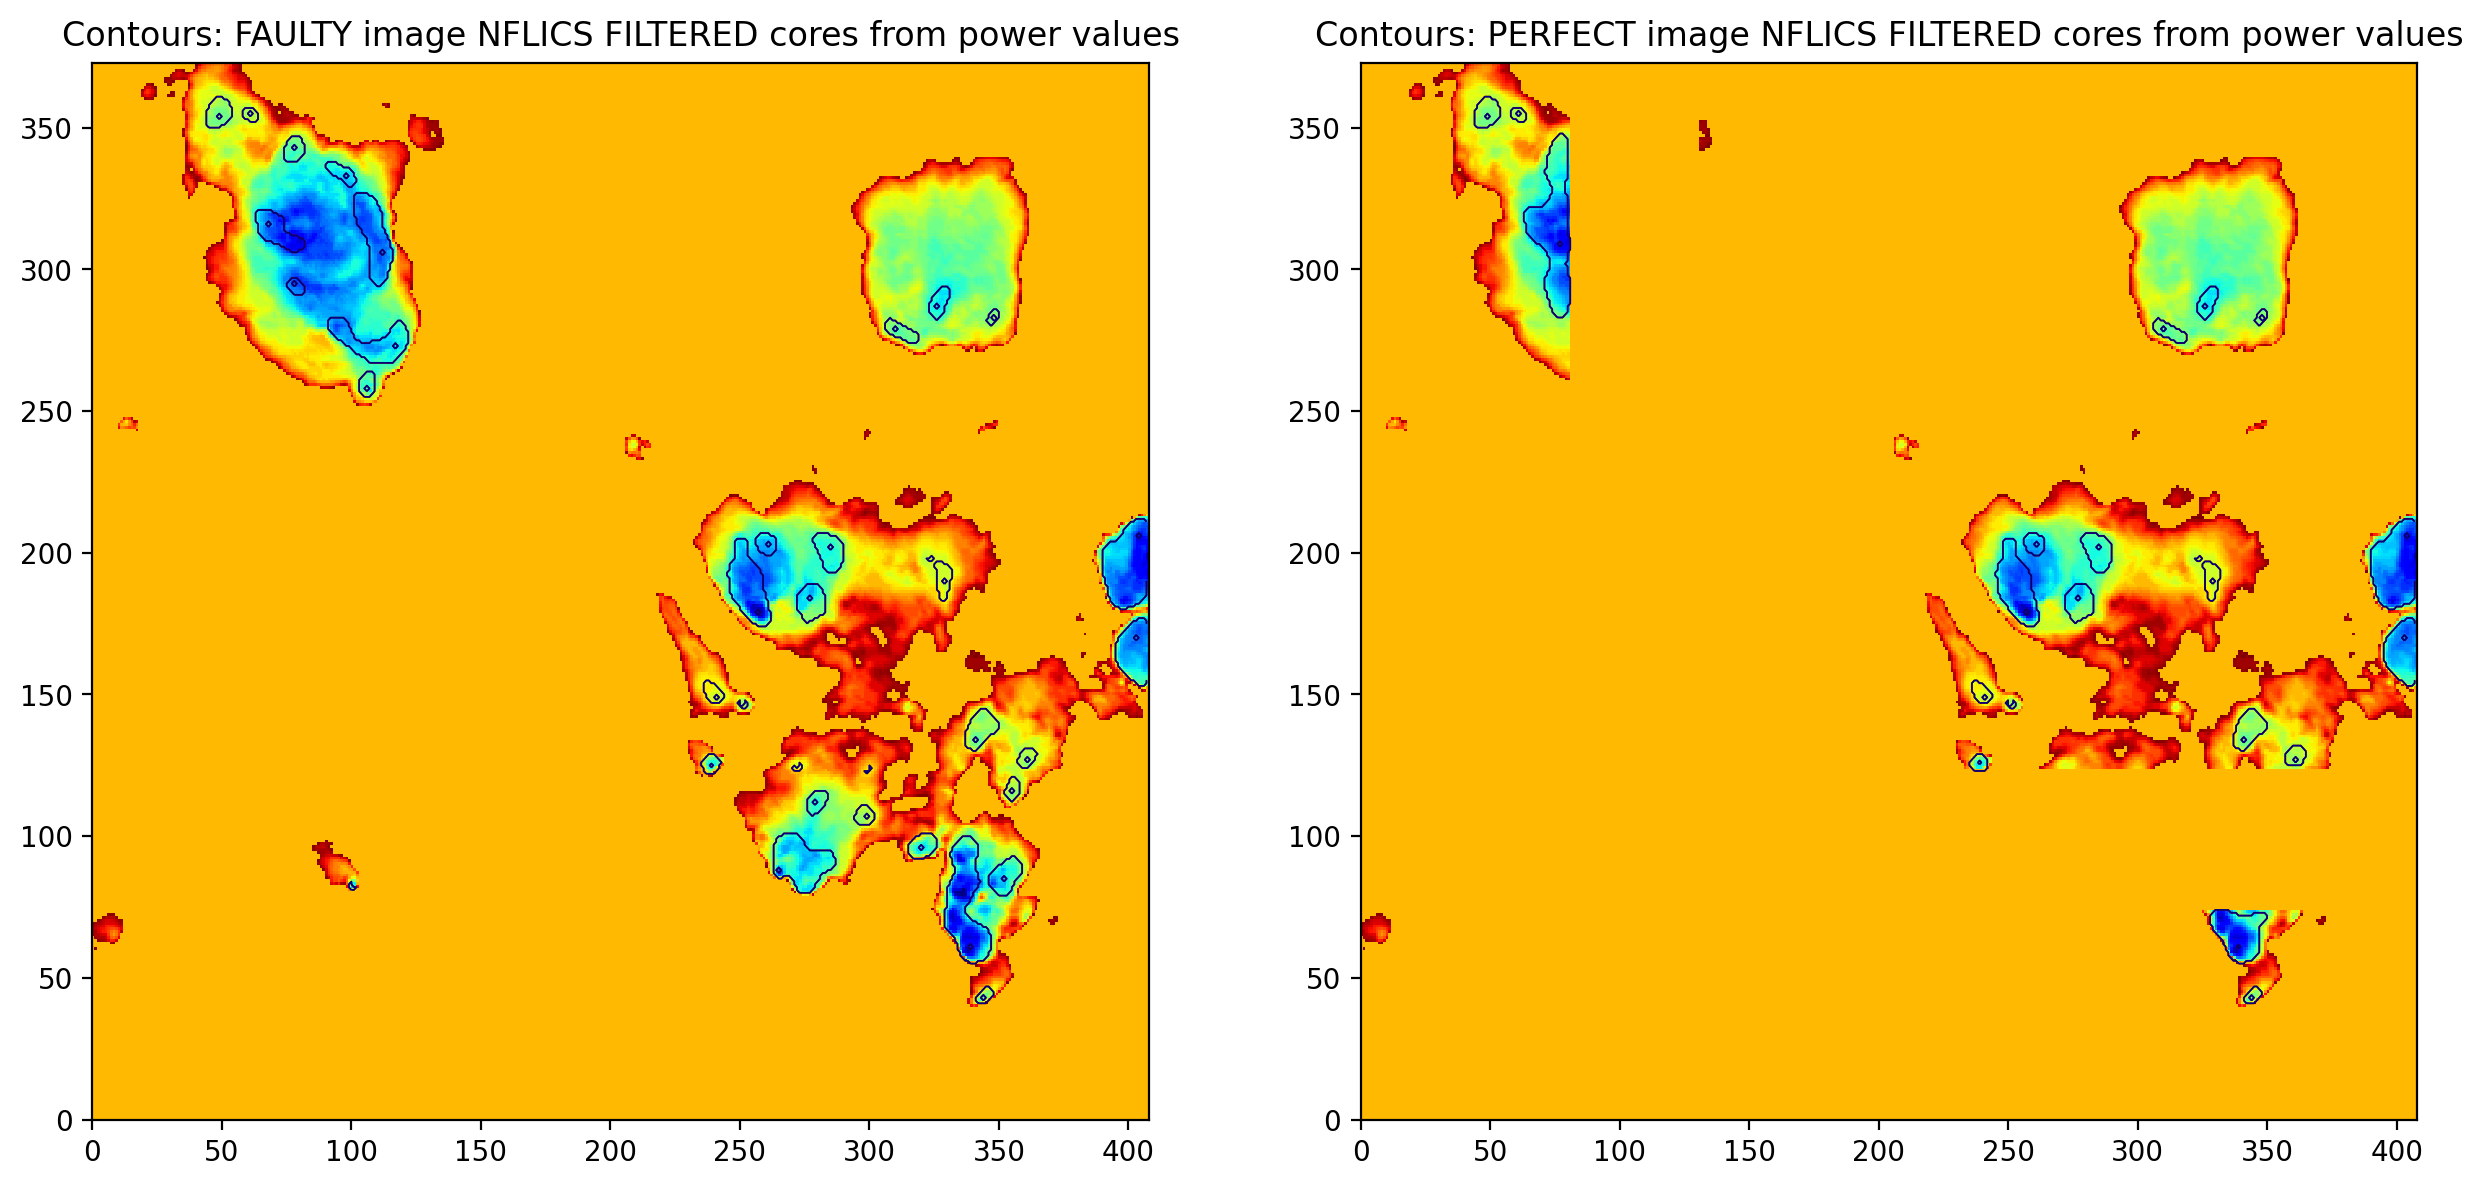

In [165]:
### For test purposes, we introduce some NaNs to create a second image

f = plt.figure(figsize=(15,7), dpi=200)

ax = f.add_subplot(121)

plt.pcolormesh(perfect_filtered_img, vmax=-50, vmin=-85, cmap='jet')

plt.contour(filtered_power, levels=[0,1], cmap='jet_r', linewidths=0.6)
plt.title('Contours: FAULTY image NFLICS FILTERED cores from power values')

ax = f.add_subplot(122)

plt.pcolormesh(nan_filtered_image, vmax=-50, vmin=-85, cmap='jet')

plt.contour(filtered_power_faulty, levels=[0,1], cmap='jet_r', linewidths=0.6)
plt.title('Contours: PERFECT image NFLICS FILTERED cores from power values')